In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
#sns.set_context('poster', font_scale=1.4)
figsize = (12, 8)
%matplotlib inline

import os

In [24]:
raw_train = pd.read_csv('../data/train.csv')
raw_test = pd.read_csv('../data/test.csv')

In [25]:
print('train shape: {}'.format(raw_train.shape))
print('test shape: {}'.format(raw_test.shape))

train shape: (159571, 8)
test shape: (153164, 2)


In [44]:
category = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

y_labels = raw_train[category].values

index_collect = []
for col in category:
    index = set(raw_train[raw_train[col] == 1].index)
    index_collect.append(index)

total = sum([len(x) for x in index_collect])
print('total number of labels: {}'.format(total))

print('total number of training data: {}'.format(raw_train.shape[0]))

total number of labels: 35098
total number of training data: 159571


Approximately 1/5 of the comments are toxic. Let's take a look whether certain observations have multiple labels.

In [27]:
counts = 0
for i in range(len(category)):
    for j in range(i+1, len(category)):
        counts += len(index_collect[i] & index_collect[j])
print('number of overlaps: {}'.format(counts))

number of overlaps: 30982


Most of the toxic observations have multiple labels 

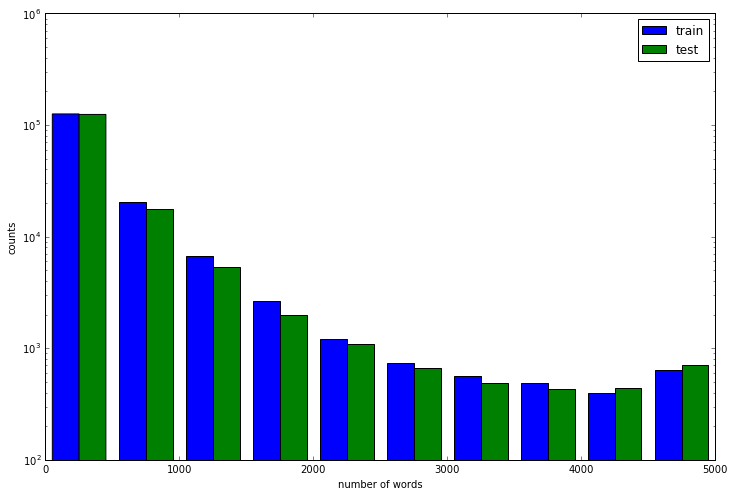

In [28]:
raw_test['doc_len'] = raw_test['comment_text'].transform(len)
raw_train['doc_len'] = raw_train['comment_text'].transform(len)

fig, ax = plt.subplots(figsize=figsize)
ax.hist([raw_train['doc_len'], raw_test['doc_len']], log=True, label=['train', 'test'])
ax.set_xlabel('number of words')
ax.set_ylabel('counts')
ax.legend(loc='best');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023ED71EEA58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000023ED6D21EF0>]], dtype=object)

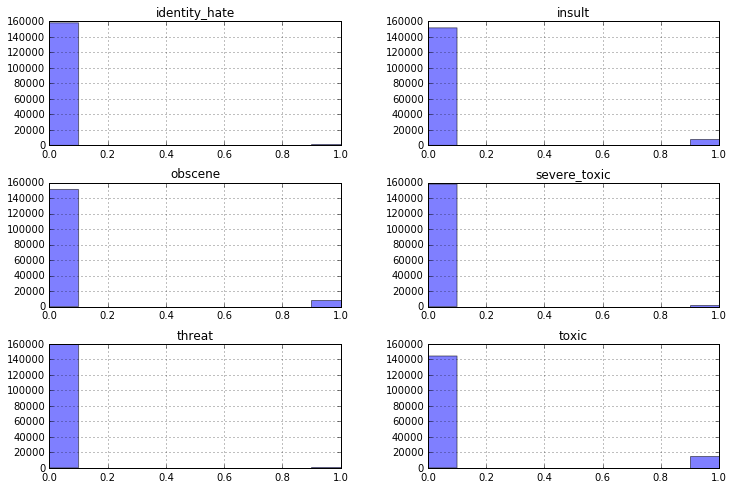

In [29]:
raw_train[category].hist(figsize=(12, 8), alpha=0.5,)

The data is highly inblance

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=10000)


train_text = list(raw_train['comment_text'])
test_text = list(raw_test['comment_text'])
all_text = train_text + test_text
#This step could cause data leaking!
#Ideally, we should not use test corpus
#to build the model!
word_vectorizer.fit(all_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [31]:
train_x = word_vectorizer.transform(train_text)
test_x = word_vectorizer.transform(test_text)

In [175]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

def get_cv_result(scores_):
    scores = scores_[1]
    mean = np.mean(scores, axis = 0)[1]
    std = np.std(scores, axis = 0)[1]
    
    return mean, std

roc = make_scorer(roc_auc_score)
lg = LogisticRegressionCV(Cs=2, scoring=roc, cv= 2)

pre_res = []

for name in category:
    train_y = raw_train[name]
    lg.fit(train_x, train_y)
    print('*****************')
    print('category: {}'.format(name))
    
    score_mean, score_std = get_cv_result(lg.scores_)
    print('mean score: {}, std: {}'.format(score_mean, score_std))
    #choose probab for lable 1
    pre_y = lg.predict_proba(test_x)[:, 1]
    pre_res.append((name, pre_y))

*****************
category: toxic
mean score: 0.8462332297833918, std: 0.0015064892734709678
*****************
category: severe_toxic
mean score: 0.656756639813993, std: 0.004349745229072777
*****************
category: obscene
mean score: 0.8402704779562081, std: 0.002747258644237527
*****************
category: threat
mean score: 0.652257671600678, std: 0.0062352969256525
*****************
category: insult
mean score: 0.7805478218118889, std: 0.005092898970408599
*****************
category: identity_hate
mean score: 0.6502078614664193, std: 0.0003296944996105111


# Naive Bayes Logistic Regression

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer()

cvec.fit(all_text)

c_train = cvec.transform(train_text)
c_test = cvec.transform(test_text)

In [178]:
import scipy.sparse as ssp


def binarinize_text(doc_matrix):
    doc_matrix[doc_matrix > 0] = 1
    return doc_matrix

def generate_p(doc_matrix, y, label):
    #generate word probablity for certain class (label)
    #return p is a matrix although one dim is 1
    m, n = doc_matrix.shape
    y = y.reshape(m)
    
    counts = np.sum(doc_matrix[y == label], axis = 0)
    counts = counts + 1
    
    p = counts / np.sum(counts)
    
    return p

def generate_r(doc_matrix, y):
    p_pos = generate_p(doc_matrix, y, 1)
    p_neg = generate_p(doc_matrix, y, 0)
    
    #calculate the discrimination power of each word
    r = np.log(p_pos/p_neg)
    
    return r

def generate_bayes_matrix(train_matrix, test_matrix, y):
    r = generate_r(train_matrix, y)
    
    num_train = train_matrix.shape[0]
    num_test = test_matrix.shape[0]
    
    #a clever way to broadcast sparse matrix with a vector
    #create a diagnal matrix with the vectors on its diagonal
    #and perform matrix multiplication
    r_train_sparse = ssp.lil_matrix((num_train, num_train))
    r_train_sparse.setdiag(r.A.flatten())

    r_test_sparse = ssp.lil_matrix((num_test, num_test))
    r_test_sparse.setdiag(r.A.flatten())
    
    bayes_train = r_train_sparse * binary_train
    bayes_test = r_test_sparse * binary_test
    
    return bayes_train, bayes_test

bayes_train shape(159571, 353967):
bayes_test shape(153164, 353967):


In [179]:
lg = LogisticRegressionCV(Cs=2, scoring=roc, cv= 2)

pre_res = []
score_collect = 0

binary_train = binarinize_text(c_train)
binary_test = binarinize_text(c_test)

for name in category:
    train_y = raw_train[name].values
    
    bayes_train, bayes_test = generate_bayes_matrix(binary_train, binary_test, train_y)
    lg.fit(bayes_train, train_y)
    
    print('*****************')
    print('category: {}'.format(name))
    
    score_mean, score_std = get_cv_result(lg.scores_)
    score_collect += score_mean
    print('mean score: {}, std: {}'.format(score_mean, score_std))
    #choose probab for lable 1
    pre_y = lg.predict_proba(bayes_test)[:, 1]
    pre_res.append((name, pre_y))
print('mean score: {}'.format(score_collect / 6))

*****************
category: toxic
mean score: 0.7802277099727796, std: 0.0013201120218996332
*****************
category: severe_toxic
mean score: 0.6493935624129465, std: 0.007025612229085765
*****************
category: obscene
mean score: 0.796044994052231, std: 0.004261680770098086
*****************
category: threat
mean score: 0.6647030642609507, std: 0.0188284949083265
*****************
category: insult
mean score: 0.7481829767588615, std: 0.0030455328848913443
*****************
category: identity_hate
mean score: 0.652171982255898, std: 0.002760312530127984


In [173]:
#function to save the submission file
def creat_sub(pre_res, notes, save=True):
    
    pre_res.insert(0, ('id', raw_test['id'].values))
    submission = pd.DataFrame(data=OrderedDict(pre_res))
    
    if save:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        path = '../submissions/'
        file_name = path + timestr + '_{}'.format(notes)
    
        submission.to_csv(file_name, index=False)
    return submission
    

In [180]:
submission = creat_sub(pre_res, 'nb_binary')

# Tests

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
corpus = ['This is the first document.', 'This is the second second document.', 
           'And the third one.', 'Is this the first document?']
vec = CountVectorizer(ngram_range=[1,1])
vec.fit(corpus)
x = vec.transform(corpus)

In [20]:
x.todense()

matrix([[0, 1, 1, 1, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 2, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [22]:
tf = TfidfTransformer()
tf_output = tf.fit_transform(x.todense())
tf_output.toarray()

array([[ 0.        ,  0.43877674,  0.54197657,  0.43877674,  0.        ,
         0.        ,  0.35872874,  0.        ,  0.43877674],
       [ 0.        ,  0.27230147,  0.        ,  0.27230147,  0.        ,
         0.85322574,  0.22262429,  0.        ,  0.27230147],
       [ 0.55280532,  0.        ,  0.        ,  0.        ,  0.55280532,
         0.        ,  0.28847675,  0.55280532,  0.        ],
       [ 0.        ,  0.43877674,  0.54197657,  0.43877674,  0.        ,
         0.        ,  0.35872874,  0.        ,  0.43877674]])